Una vez tengo el banco de pruebas del data augmentation, lo que pretendo hacer es una función llamada aumento que aleatoriamente 
aplique a la imagen una transformación. Para ello lo que haré será generar un número aleatorio entre 0 y 1 y según en el rango en el que caiga así hacemos.

In [1]:
import tensorflow as tf
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random

In [7]:
#  La función va a tener como parámetro un dataset
def aumento(img):
    # Creo el número aleatorio
    numero_aleatorio = random.uniform(0, 1)

    # Ahora controlo qué aumento se hace en  función de ese número
    if numero_aleatorio < 0.1:
        
        # 0 means flipping around the x-axis 
        # 1 means flipping around y-axis
        # -1 means flipping around both axes.
        aleat = random.randint(-1, 1)
        augmented = cv2.flip(img, aleat)
        
    elif numero_aleatorio < 0.2:

        # Numero aleatorio entre 0 y 360 para hacer la rotacion
        aleat = random.randint(0,360)
        alto, ancho = img.shape[:2]
        centro = (ancho // 2, alto // 2)
        matriz_rotacion = cv2.getRotationMatrix2D(centro, aleat, 1.0)
        augmented = cv2.warpAffine(img, matriz_rotacion, (ancho, alto), flags=cv2.INTER_LINEAR)

    elif numero_aleatorio < 0.3:

        augmented = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        
    elif numero_aleatorio < 0.4:

        # Blur Gaussiano
        
        aleat = random.randint(0,7)
        aleat = aleat if aleat % 2 != 0 else aleat + 1
        augmented=np.copy(img)
        augmented[:, :, 0] = cv2.GaussianBlur(img[:, :, 0], (aleat,aleat), 0)  # Canal R
        augmented[:, :, 1] = cv2.GaussianBlur(img[:, :, 1], (aleat,aleat), 0)  # Canal G
        augmented[:, :, 2] = cv2.GaussianBlur(img[:, :, 2], (aleat,aleat), 0)  # Canal B
        
    elif numero_aleatorio < 0.5:

        # Dilatación
        a = random.randint(0,7)
        b = random.randint(0,7)
        kernel = np.ones((a,b),np.uint8)
        augmented = cv2.dilate(img,kernel,iterations = 1)
        
    elif numero_aleatorio < 0.6:

        a = random.uniform(8,11)
        kernel = np.array([[-1,-1,-1], [-1,a,-1], [-1,-1,-1]])
        augmented = cv2.filter2D(img, -1, kernel)
        
    elif numero_aleatorio < 0.7:

        # Cizalla
        a = random.uniform(-0.3,0.3)
        b = random.uniform(-0.3,0.3)
        alto, ancho = img.shape[:2]
        M = np.float32([[1, a, 0],   
                       [b, 1, 0]])
        augmented = cv2.warpAffine(img, M, (ancho, alto))
        
    elif numero_aleatorio < 0.8:

        # Traslacion
        a = random.randint(-45,45)
        b = random.randint(-45,45)
        M_traslacion = np.float32 ([[1, 0, a],
                                   [0, 1, b]])
        alto, ancho = img.shape[:2]
        augmented = cv2.warpAffine(img, M_traslacion, (ancho, alto))
        
    elif numero_aleatorio < 0.9:

        # Ruido
        a = random.uniform(0,0.6)
        ruido = np.random.normal(0, a, img.shape).astype(np.uint8)
        augmented = cv2.add(img, ruido)
        
    elif numero_aleatorio <= 1:

        # Contraste
        a = random.uniform(0.8,1.8)
        augmented = cv2.convertScaleAbs(img, alpha=a, beta=0)

    return augmented

In [11]:
def visualize(original, aumentada):
    fig = plt.figure()
    plt.subplot(1,2,1)
    plt.title('484x484')
    plt.imshow(original)
    plt.axis('off')

    plt.subplot(1,2,2)
    plt.title('100x100')
    plt.imshow(aumentada)
    plt.axis('off') 

In [9]:
img_path = '..\\..\\Data\\Images\\fpC-000752-40-6-0489-0232.jpg'
img = cv2.imread(img_path)

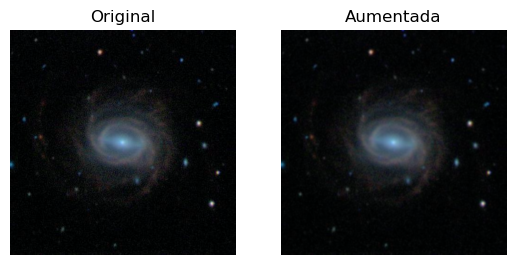

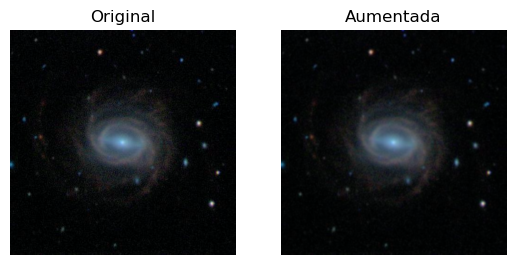

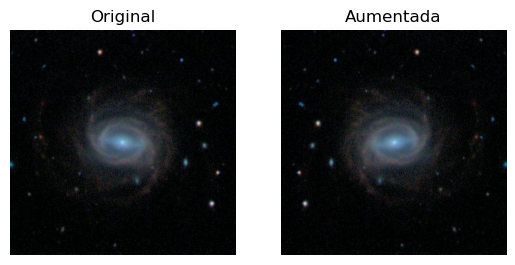

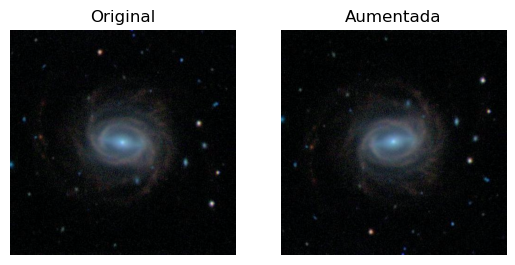

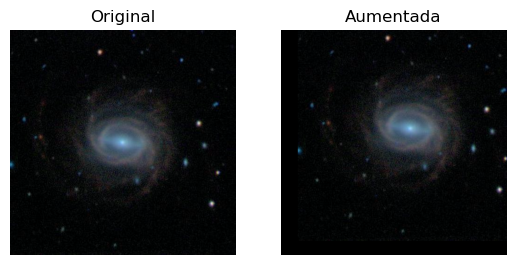

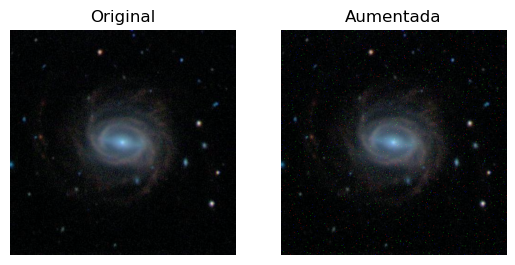

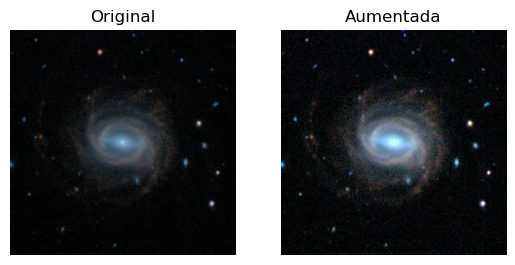

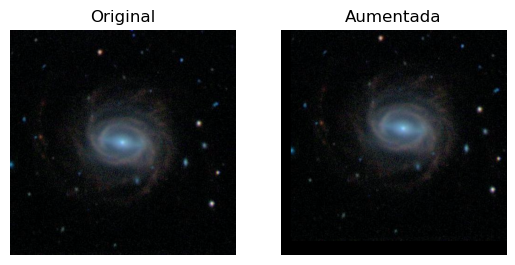

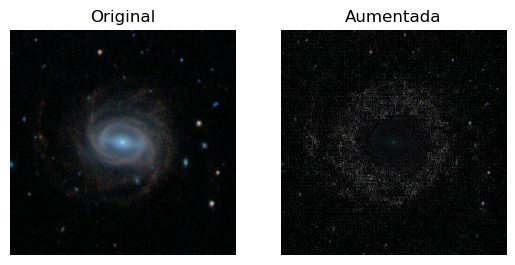

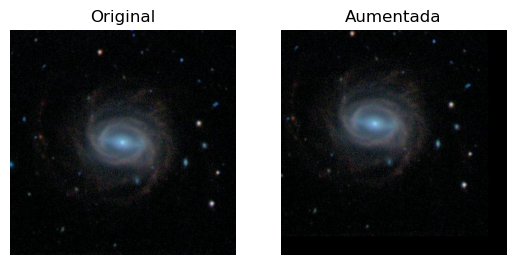

In [10]:
for i in range(0,10):
    aumentada = aumento(img)
    visualize(img,aumentada)

HASTA AQUÍ LA FUNCIÓN DE DATA AUGMENTATION. COMO VES LA IMAGEN DEBE SER LEIDA POR CV2
-

AHORA MUESTRO EL FALLO QUE ME DA CON EL DATASET EN TENSOR FLOW. 

ES CURIOSO PORQUE SOLO DA FALLO AL HACER EL .MAP

SI ACCEDO AL DATASET Y COJO LA PIRMERA TUPLA TENSOR-LABEL, LA FUNCIÓN HACE LA TRANSFORMACIÓN DE TENSOR A .NUMPY() 
PERFECTAMENTE Y HACE EL AUMENTO. 

PERO CUANDO LE HAGO EL .MAP AL DATASET ENTERO NO.



In [193]:
def tf_aumento(img, label):
    # Creo el número aleatorio
    numero_aleatorio = random.uniform(0,0.8)
    # Ahora controlo qué aumento se hace en  función de ese número
    if numero_aleatorio < 0.1:
        
        augmented = tf.image.flip_left_right(img)

    elif numero_aleatorio < 0.2:

        augmented = tf.image.flip_up_down(img)
        
    elif numero_aleatorio < 0.3:

        augmented = tf.image.rot90(img, random.randint(0,3))

    elif numero_aleatorio < 0.4:

        augmented = tf.image.rgb_to_grayscale(img)
        
    elif numero_aleatorio < 0.5:
        
        a = random.uniform(-0.1,0.2)
        augmented = tf.image.adjust_brightness(img, a)
        
    elif numero_aleatorio < 0.6:

        a = random.uniform(1,1.5)
        b = random.uniform(1,2)
        augmented = tf.image.adjust_gamma(img, a, b)
        
    elif numero_aleatorio < 0.7:

        a = random.uniform(0,2.5)
        augmented = tf.image.adjust_saturation(img, a)
        
    elif numero_aleatorio <= 8:

        a = random.uniform(1,2.5)
        augmented = tf.image.adjust_contrast(img, a)
        
    return augmented, label

In [3]:
def cargar(imagen,label):
    image_bytes = tf.io.read_file(imagen)
    image = tf.image.decode_jpeg(image_bytes, channels=3)
    return image, label

In [4]:
def normalizar(imagen,label):
    image = tf.cast(imagen, tf.float32)
    image /= 255.
    return image, label

In [5]:
def resize(imagen,label):
    imagen = tf.image.resize(imagen, (100,100))
    return imagen,label

In [7]:
# Voy a crear un dataset con la imagen que te paso y su etiqueta
img_path = '..\\..\\Data\\Images\\fpC-000752-40-6-0489-0232.jpg'

# Dos listas, una con el path y otra con la etiqueta. Realmente la etiqueta da igual
imagen = [img_path]
label = [0]

# Creo el dataset
train_ds = tf.data.Dataset.from_tensor_slices((imagen, label))
# Ahora quiero cargar las imágenes en tensorflow. Aplico la función cargar.
train_ds = train_ds.map(cargar, tf.data.experimental.AUTOTUNE)
# Mormalizo los píxeles
train_ds = train_ds.map(normalizar, tf.data.experimental.AUTOTUNE)
# Hago un resize para equiparar todas las imágenes. Las dimensiones serán de 100x100.

In [ ]:

train_ds = train_ds.map(resize, tf.data.experimental.AUTOTUNE)

In [16]:
# Ahora aplico un .map con la función de aumento
train_ds = train_ds.map(tf_aumento, tf.data.experimental.AUTOTUNE)

AQUÍ YA ME SALTA EL ERROR. PARA QUE VEAS QUE SI ACCEDO AL TENSOR Y AL LABEL NO OCURRE ESE ERROR TE MUESTRO ABAJO EL EJEMPLO

(484, 484, 3)
(100, 100, 3)


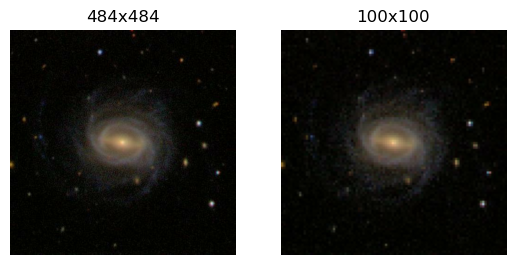

In [12]:
for img,label in train_ds.take(1):
    img_aug,label = resize(img,label)
    print(img.shape)
    print(img_aug.shape)
    visualize(img, img_aug)
    

SI PROBANDO LA FUNCION DE AUMENTO VES ALGUN CAMBIO EXCESIVO NO TE ASUSTES. SIMPLEMENTE QUIERO QUE VEAS QUE SI ACCEDO AL DTASET FUNCIONA, Y SI HAGO MAP NO.

TAMBIÉN VI UNA FUNCION LLAMADA TF.PY_FUNCTION QUE PARECE AYUDAR CON ESTAS COSAS, PERO CUANDO HAGO EL .MAP, SE ME DESTROZA LA FORMA DE MI DATASET

In [42]:
# Forma antes
print('Forma antes del tf.py_function',train_ds)


Forma antes del tf.py_function <_ParallelMapDataset element_spec=(TensorSpec(shape=(100, 100, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int32, name=None))>


In [119]:
train_ds = train_ds.map(lambda image, label: tf.py_function(aumento, [image, label], [tf.float32, tf.int32]), tf.data.experimental.AUTOTUNE)
print('Forma despues del tf.py_function',train_ds)

Forma despues del tf.py_function <_ParallelMapDataset element_spec=(TensorSpec(shape=<unknown>, dtype=tf.float32, name=None), TensorSpec(shape=<unknown>, dtype=tf.int32, name=None))>


Y CLARO, CON ESTA FORMA NO PUEDO ENTRENAR, OBVIAMENTE. NO SE SI HAY ALGUNA FORMA DE VOLVER A DARLE LA FORMA DESEADA. REALMENTE NO SE QUÉ ESTÁ HACIENDO LO DE TF.PY_FUNCTION.